# 02/10/21 - This notebook consolidates ideas developed in notebook 012921_preparing_first_model.
# 02/12/21 - Should be good to go! Saved fits files of g, r, and i image, noise_map, and psf

In [1]:
### libraries
%matplotlib inline
import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import scipy.stats as stats
from astropy.stats import sigma_clip as clip

from pyprojroot import here

workspace_path = '/data/sknabel/autolens_workspace'
#workspace_path = '~/Desktop/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")
# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
#autoz_path = '/home/shawn/Desktop/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'


Bad key "text.kerning_factor" on line 4 in
/soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


/data/sknabel/autolens_workspace
Working Directory has been set to `/data/sknabel/autolens_workspace`


## I am selecting G3575500 (1906) with score of	26, redshifts 0.232537 and 0.365195, mass 3.049251e+11, and $\theta_E$	1.296096 and 0.762649

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  101 / Number of pixels along this axis               
NAXIS2  =                  101 / Number of pixels along this axis               
EXTEND  =                    T / This file may contain FITS extensions          
OBJECT  = 'KIDS_129.0_-1.5'                                                     
ZEROPNT =                  0.0                                                  
ZPNTERR =                  0.0                                                  
CREADATE= '2017-05-05T23:15:48.000'                                             
PSF_RAD =   0.5450006723403931                                                  
INSTRUME= 'OMEGACAM'                                                            
TELESCOP= 'ESO-VLT-U0'      

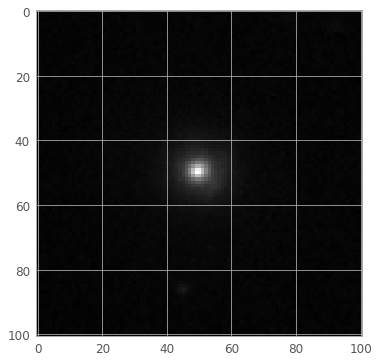

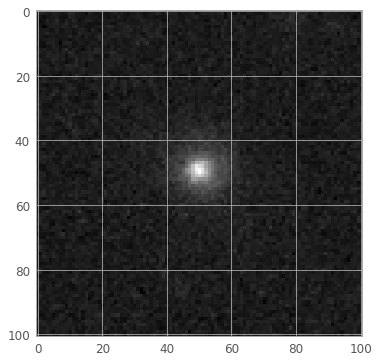

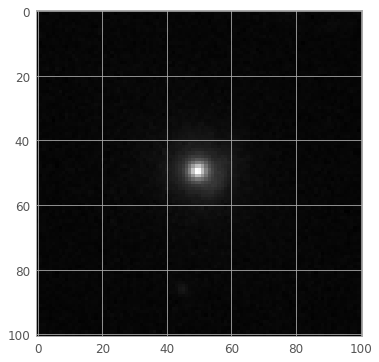

In [2]:
# Let's look at r-band image
folder = f'{fits_path}G3575500_1906/'
r = '1906_r.fits'
g = '1906_g.fits'
i = '1906_i.fits'
# get the files ready
# r
hdul = fits.open(f'{folder}{r}') # open the fits
print(repr(hdul[0].header))
#print(hdul.info())
r_image = hdul[0].data # select first HDU to be the image
hdul.close()
# g
hdul = fits.open(f'{folder}{g}') # open the fits
print(repr(hdul[0].header))
#print(hdul.info())
g_image = hdul[0].data # select first HDU to be the image
hdul.close()
# i
hdul = fits.open(f'{folder}{i}') # open the fits
print(repr(hdul[0].header))
#print(hdul.info())
i_image = hdul[0].data # select first HDU to be the image
hdul.close()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(r_image, cmap='gray') # show image in grayscale
plt.show()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(g_image, cmap='gray') # show image in grayscale
plt.show()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(i_image, cmap='gray') # show image in grayscale
plt.show()


In [3]:
# this is where it doesn't make sense... supposedly the flux units allow you to immediately 
# take the magnitude, which involves the log of these values (negative values), which is impossible.
r_image

array([[-4.5750041e-13, -3.0575938e-14, -1.5436617e-12, ...,
        -2.4618356e-12, -7.2580315e-13,  3.9924574e-12],
       [-2.6780253e-12, -3.4066933e-13,  4.2515861e-12, ...,
        -1.7257774e-12, -1.8844701e-13,  3.5146708e-12],
       [-2.7815482e-12, -6.1849283e-13,  2.1626472e-12, ...,
        -2.0837368e-12, -6.4451542e-13,  2.4700459e-12],
       ...,
       [ 2.6106016e-12,  1.2915887e-12, -6.6080268e-13, ...,
        -7.0498398e-13,  2.5281270e-12,  4.1778564e-12],
       [ 1.3455720e-13,  8.1124571e-13,  1.2461902e-12, ...,
         2.2593427e-12,  9.0976888e-14,  6.0948468e-13],
       [-9.4347360e-13,  4.4129443e-13, -3.5649172e-12, ...,
         3.8082224e-12, -1.1755337e-12, -2.1614546e-12]], dtype=float32)

## g-band image contains the lensed source features.

In [4]:
# write the individual modules of the function

# get info from fits header
def reveal_yourself(header):
    # take the gain
    gain = header['GAIN']
    # take the psf
    psf = header['PSF_RAD']
    # take the filter
    gri_filter = header['FILT_ID']
    # take exposure time
    if gri_filter == 'OCAM_g_SDSS':
        exp_time = 900
    elif gri_filter == 'OCAM_r_SDSS':
        exp_time = 1800
    elif gri_filter == 'OCAM_i_SDSS':
        exp_time = 1200
    else:
        print('Error - filter not g, r, or i')
    print(f'Here we go again... psf = {psf}, gain = {gain}')
    return(psf, gain, exp_time)

def count_chocula(image, gain):
    image_counts = image*gain # create array in electron counts
    print('1, 2... 2 counts!')
    return(image_counts)

# resize
def resize_image(image, new_size):
    print(f'Resizing image to {new_size}.')
    size=image.shape[0] # 101
    center=int(image.shape[0]/2) # 50
    new_center=(new_size-1)/2
    lower = int(center-new_center) 
    upper = int(center+new_center)
    resized_image=image[lower:upper+1,lower:upper+1]
    print(f'Middle pixel at index {center}. New image created from indices {lower} to {upper} in axes 0 and 1.')
    print(f'New shape: {resized_image.shape}')
    print(f'New things are good!')
    return(resized_image)

# generate noise_map
def get_noisey (image, new_size, exp_time):
    
    plt.figure()
    plt.title = (f'{hdul[0].header[6]} signal')
    plt.hist(np.ravel(image),bins=100)#,log=True) # plot signal in histogram
    plt.show()
    print(f'Image - Mean {np.mean(image)}, Median {np.median(image)}, Min {np.min(image)}, Max {np.max(image)}')
    
    # clip to 3sigma around median
    print('Clipping to 3-sigma about median value')
    clipped_image=clip(image, cenfunc='median', sigma=3)
    
    # generate Gaussian noise about mean and std # don't use this to make noise... use the std to make the background sky level
    mean = np.mean(clipped_image) # mult by 2 or something (maybe 10)
    std = np.std(clipped_image)
    #noise_gaussian = np.random.normal(loc=mean, # what if i just take the mean... and add 10*mean to it. Then subtract that again. 
    #                                        scale=std,
    #                                        size= np.ravel(clipped_image).shape)
    #plt.hist(noise_gaussian, bins=100, density=True, label='Gaussian Fit')
    
    print(f'Numpy Background Noise: mean {mean}, std {std}')
    #plt.hist(background_noise)
    #alternative method with scipy.norm.fit ... for whatever reason it is giving me nonsense answers here.
    #binned_image = np.ravel(clipped_image)
    #fit_mean, fit_std =  stats.norm.fit(binned_image) # new idea, use the std of the gaussian to be the constant bg sky level
    #print(f'Scipy fit Background Noise: mean {mean}, std {std}')
    #background_noise = np.random.normal(loc=mean, # what if i just take the mean... and add 10*mean to it. Then subtract that again. 
    #                                        scale=std,
    #                                        size= image.shape)
    plt.figure()
    plt.hist(np.ravel(clipped_image),bins=100, density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std)
    #p2 = stats.norm.pdf(x, fit_mean, fit_std)
    plt.plot(x, p, 'k', linewidth=2)
    #plt.plot(x, p2, 'r', linewidth=2)
    plt.show()\
    # take std to be estimate of background sky level
    print(f'Background sky level is std of the Gaussian: {np.around(std, 3)}')
    background_sky = std
    background_sky_eps = background_sky/exp_time
    #mean_bg_noise_eps = np.mean(background_noise_eps)
    print(f'Background Noise eps: mean {np.around(background_sky_eps, 3)}, should be around 10-100 eps according to K. Kuijken')
    #print(f'Background Noise eps: min {np.around(np.min(background_noise_eps))}')
    # add background to image and take sqrt() to get noise map
    print()
    noise_map = np.sqrt(image+background_sky)# - np.sqrt(10*mean)
    # sigma clipping should be same as original data sigma clipping
    plt.figure()
    #plt.title=(f'{hdul[0].header[6]} noise')
    plt.hist(np.ravel(noise_map),bins=100,log=True) # plot signal in histogram
    plt.show()
    print(np.min(noise_map))
    
    print('What if we bullshit it and say the background sky is 100 eps.')
    bullshit = 100*exp_time
    noise_map = np.sqrt(image+bullshit)
    
    # resize noise map
    noise_map_resized = resize_image(noise_map, new_size)
    print(f'New noise_map shape: {noise_map_resized.shape}')
    return (noise_map, noise_map_resized)

# generate psf
def point_to_the_spread(image, psf, pixel_scale, new_size):

    # define psf values
    avg_psf = psf # arcsec
    avg_psf_pxl = avg_psf/pixel_scale # pixels
    sigma_psf = avg_psf_pxl/2
    size = int(np.around(image.shape[0]/2)) # gives a grid of 101 (50 on either side of the center)
    
    # set psf for 101, 101 image
    y, x = np.mgrid[-size:size+1, -size:size+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
    psf /= np.sum(psf)
    print(f'A psf of {psf} with size {size} has been generated')
    
    # resize psf
    psf_resized = resize_image(psf, new_size) # cut to 21x21
    print(f'New psf shape: {psf_resized.shape}')
    
    # good vibes
    print('This has been fun, right? Very fun! :)')
    
    return(psf, psf_resized)



In [5]:
# write one function to do all of it.
def one_ring_to_rule_them_all(folder, file, pixel_scale, psf_array_size, new_size=0, resize=False):
    
    print('One ring to rule them all... One ring to find them. One ring to bring them all, and in the darkness bind them!')
    print('Images will be in units of e-/s')
    
    # extract fits file
    print(f'Opening {folder}{file}')
    hdul = fits.open(f'{folder}{file}') # open the fits
    image = hdul[0].data
    header = hdul[0].header
    hdul.close()
    
    # pull out header info
    psf, gain, exp_time = reveal_yourself(header)
    
    print(f'image min: ', np.min(image))
    # convert to counts
    image_counts = count_chocula(image, gain)
    print(f'image_counts min: ', np.min(image_counts))
    # resize
    if resize==True:
        image_resized = resize_image(image_counts, new_size)
    
    # generate the noise_map
    noise_map, noise_map_resized = get_noisey(image_counts, new_size, exp_time)
    
    
    # generate the psf
    psf, psf_resized = point_to_the_spread(image_counts, psf, pixel_scale, psf_array_size)
    
    # convert image and noise_map to e-/s
    image_eps = image_counts/exp_time 
    image_resized_eps = image_resized/exp_time
    noise_map_eps = noise_map/exp_time
    noise_map_resized_eps = image_resized/exp_time
    
    print(image_eps.mean, image_eps.std)
    
    
    # plot everything
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))
    ax1.imshow(image_eps, cmap='Spectral')
    ax1.set_title('Image')
    if resize==True:
        ax2.imshow(image_resized_eps, cmap='Spectral')
        ax2.set_title(f'Image resized to {new_size}')
    ax3.imshow(psf, cmap='Spectral')
    ax3.set_title(f'PSF')
    ax4.imshow(psf_resized, cmap='Spectral')
    ax4.set_title(f'PSF resized to {psf_array_size}')
    ax5.imshow(noise_map_eps, cmap='Spectral')
    ax5.set_title(f'Noise Map')
    ax6.imshow(noise_map_resized_eps, cmap='Spectral')
    ax6.set_title(f'Noise Map resized to {new_size}')
    
    # save the images and psf's to fits
    # counts image
    hdu = fits.PrimaryHDU(image_eps)
    hdu.writeto(f'{folder}{file[:-5]}_image.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_image.fits')
    # counts image resized
    if resize==True:
        hdu = fits.PrimaryHDU(image_resized_eps)
        hdu.writeto(f'{folder}{file[:-5]}_image_resized.fits', overwrite=True)
        print(f'Image sent to {folder}{file[:-5]}_image_resized.fits')  
    # psf
    hdu = fits.PrimaryHDU(psf)
    hdu.writeto(f'{folder}{file[:-5]}_psf.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf.fits')  
    # psf resized
    hdu = fits.PrimaryHDU(psf_resized)
    hdu.writeto(f'{folder}{file[:-5]}_psf_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf_resized.fits')
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map_eps)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap.fits')
    # write noise map
    hdu = fits.PrimaryHDU(noise_map_resized_eps)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap_resized.fits')
    # good vibes
    print('Congratulations! You simulated random noise! Eat a cookie.')
    # good vibes
    print('This has been fun, right? Very fun! :)')

One ring to rule them all... One ring to find them. One ring to bring them all, and in the darkness bind them!
Images will be in units of e-/s
Opening /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
Here we go again... psf = 0.5450006723403931, gain = 31335183770000.0
image min:  -7.512851e-12
1, 2... 2 counts!
image_counts min:  -235.41655
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!


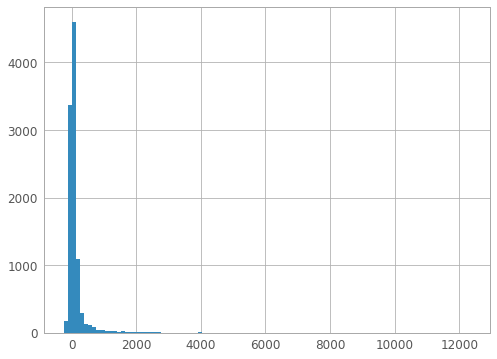

Image - Mean 140.2788543701172, Median 48.145423889160156, Min -235.4165496826172, Max 12325.8203125
Clipping to 3-sigma about median value
Numpy Background Noise: mean 46.179943510387666, std 83.74209192816103


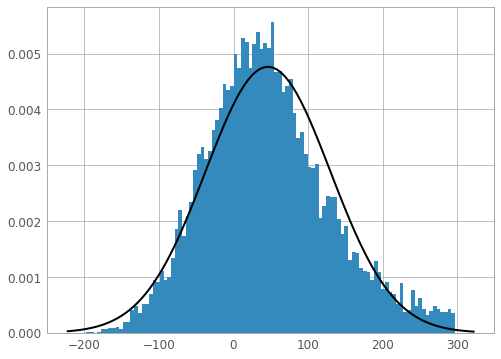

Background sky level is std of the Gaussian: 83.742
Background Noise eps: mean 0.047, should be around 10-100 eps according to K. Kuijken



/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


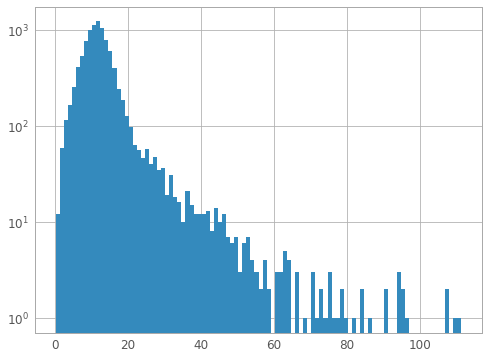

nan
What if we bullshit it and say the background sky is 50 eps.
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!
New noise_map shape: (51, 51)
A psf of [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] with size 50 has been generated
Resizing image to 21.
Middle pixel at index 50. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New things are good!
New psf shape: (21, 21)
This has been fun, right? Very fun! :)
<built-in method mean of numpy.ndarray object at 0x7fd19c961a80> <built-in method std of numpy.ndarray object at 0x7fd19c961a80>
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_image.fits
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_image_resized.fits
Image sent to /data/sknabel/autoz_lens_m

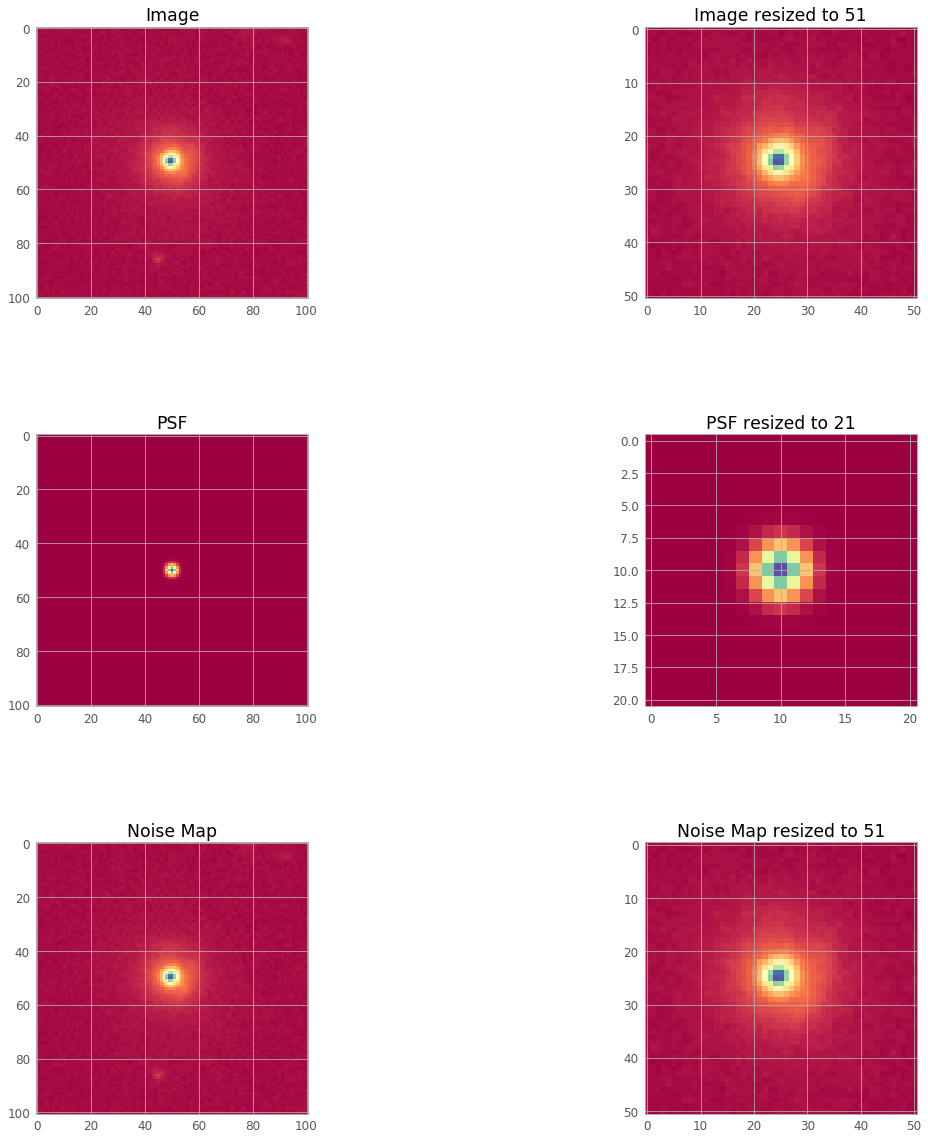

In [234]:
# try it out
one_ring_to_rule_them_all(folder, r, pixel_scale=0.2, psf_array_size=21, resize=True, new_size=51)

In [217]:
# It works!!!!

One ring to rule them all... One ring to find them. One ring to bring them all, and in the darkness bind them!
Images will be in units of e-/s
Opening /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g.fits
Here we go again... psf = 0.7095126152038574, gain = 17595101220000.0
image min:  -7.65266e-12
1, 2... 2 counts!
image_counts min:  -134.64932
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!


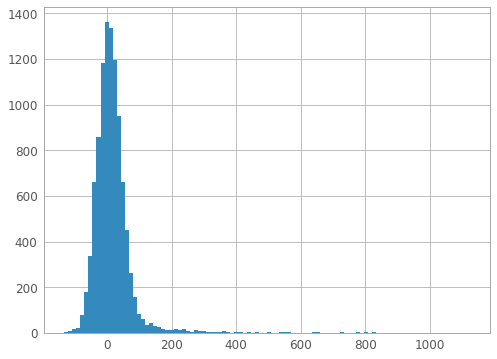

Image - Mean 16.104312896728516, Median 7.846445560455322, Min -134.64932250976562, Max 1125.102783203125
Clipping to 3-sigma about median value
Numpy Background Noise: mean 7.110466335400569, std 36.347387375541246


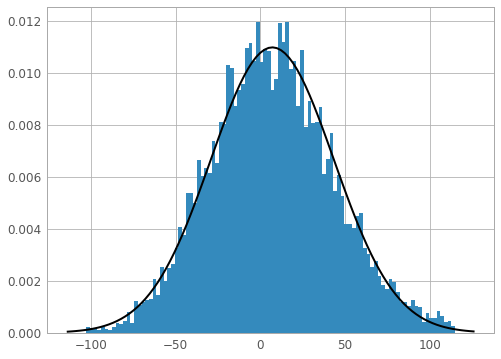

Background sky level is std of the Gaussian: 36.347
Background Noise eps: mean 0.04, should be around 10-100 eps according to K. Kuijken



/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


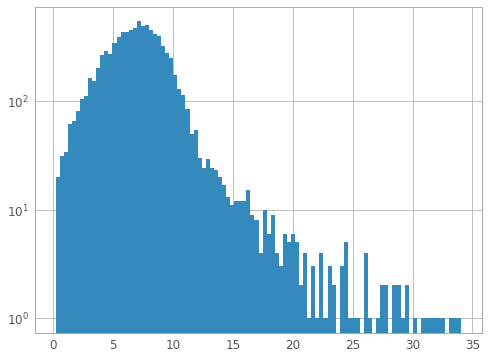

nan
What if we bullshit it and say the background sky is 50 eps.
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!
New noise_map shape: (51, 51)
A psf of [[0.000e+000 0.000e+000 0.000e+000 ... 0.000e+000 0.000e+000 0.000e+000]
 [0.000e+000 0.000e+000 0.000e+000 ... 0.000e+000 0.000e+000 0.000e+000]
 [0.000e+000 0.000e+000 4.733e-320 ... 4.733e-320 0.000e+000 0.000e+000]
 ...
 [0.000e+000 0.000e+000 4.733e-320 ... 4.733e-320 0.000e+000 0.000e+000]
 [0.000e+000 0.000e+000 0.000e+000 ... 0.000e+000 0.000e+000 0.000e+000]
 [0.000e+000 0.000e+000 0.000e+000 ... 0.000e+000 0.000e+000 0.000e+000]] with size 50 has been generated
Resizing image to 21.
Middle pixel at index 50. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New things are good!
New psf shape: (21, 21)
This has been fun, right? Very fun! :)
<built-in method mean of numpy.ndarray object at 0x7fb034e6df30> 

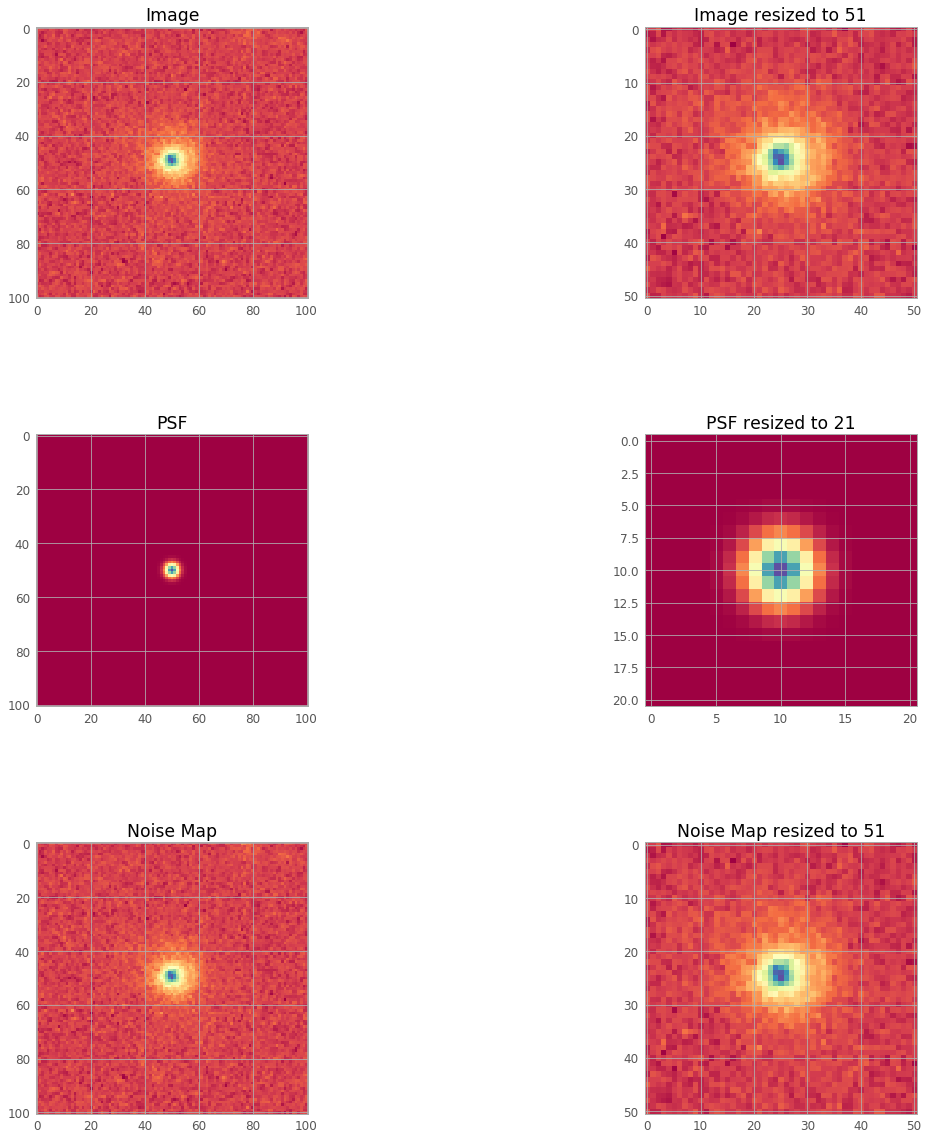

In [6]:
# Now for green
# try it out
one_ring_to_rule_them_all(folder, g, pixel_scale=0.2, psf_array_size=21, resize=True, new_size=51)

One ring to rule them all... One ring to find them. One ring to bring them all, and in the darkness bind them!
Images will be in units of e-/s
Opening /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i.fits
Here we go again... psf = 0.5903135299682617, gain = 13855488830000.0
image min:  -1.6316523e-11
1, 2... 2 counts!
image_counts min:  -271288.06
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!


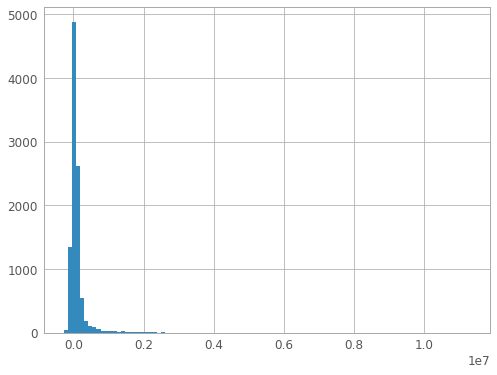

Image - Mean 130051.7734375, Median 48194.05078125, Min -271288.0625, Max 11316103.0
Clipping to 3-sigma about median value
Numpy Background Noise: mean 46437.73783726365, std 84421.66876545853


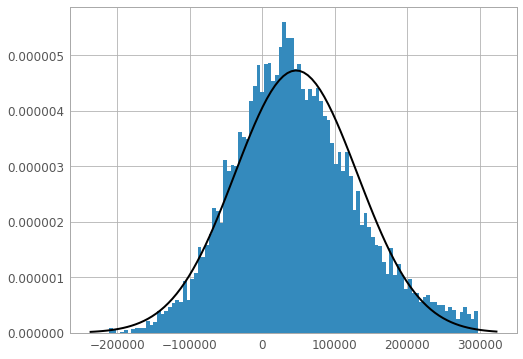

Background sky level is std of the Gaussian: 84421.66900000001
Background Noise eps: mean 70.351, should be around 10-100 eps according to K. Kuijken



/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


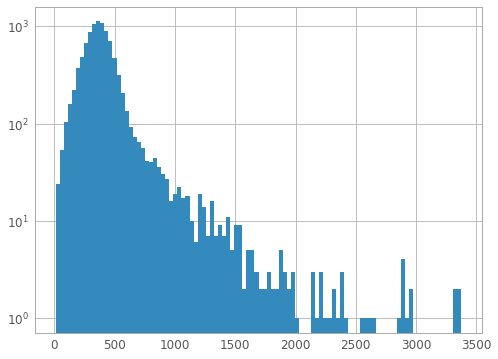

nan
What if we bullshit it and say the background sky is 40 eps, assume gain=10 e-/ADU...
Resizing image to 51.
Middle pixel at index 50. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New things are good!
New noise_map shape: (51, 51)
A psf of [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] with size 50 has been generated
Resizing image to 21.
Middle pixel at index 50. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New things are good!
New psf shape: (21, 21)
This has been fun, right? Very fun! :)
<built-in method mean of numpy.ndarray object at 0x7fd19dddb670> <built-in method std of numpy.ndarray object at 0x7fd19dddb670>
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_image.fits
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_image_resized.fits
Image sent to /

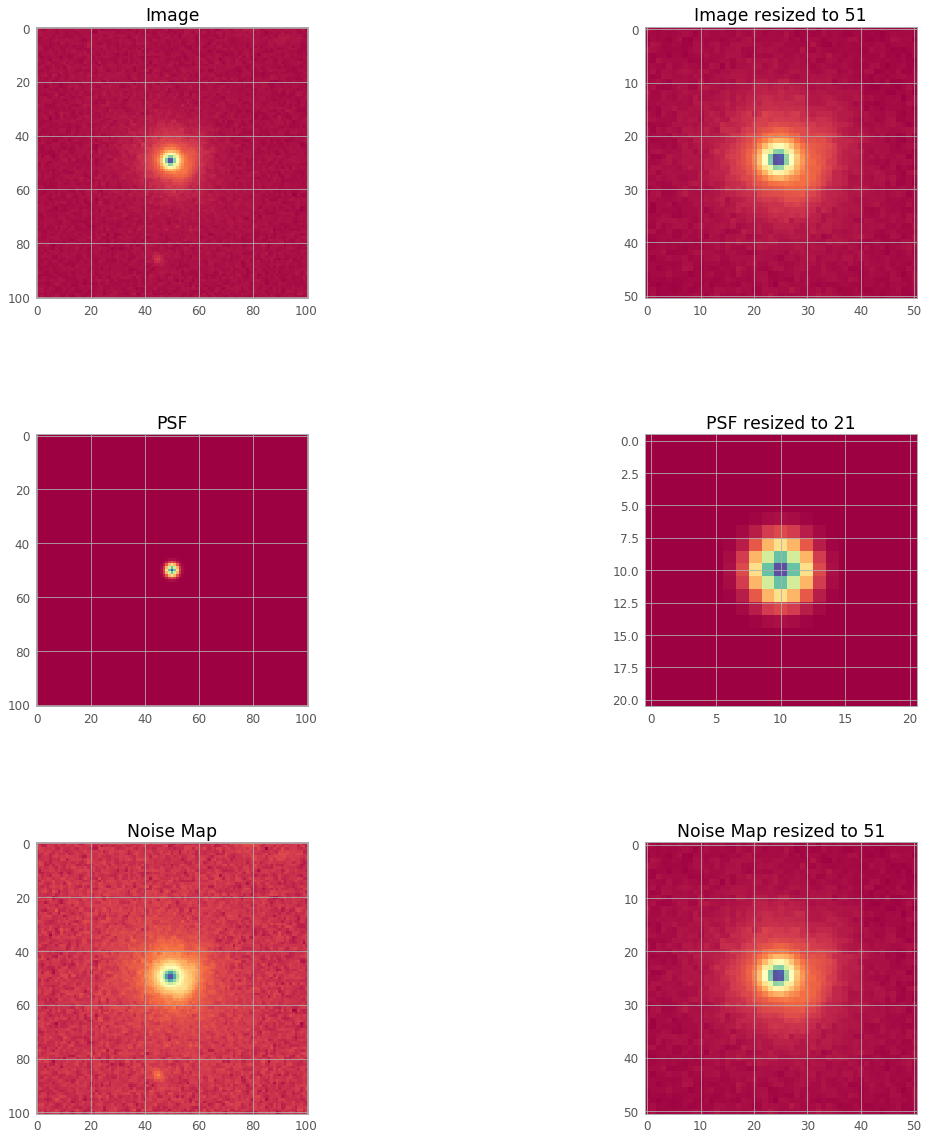

In [213]:
# and i
# try it out
one_ring_to_rule_them_all(folder, i, pixel_scale=0.2, psf_array_size=21, resize=True, new_size=51)

99.89169424040959 10.016221164244378
99.89169424040959 10.016221164244378


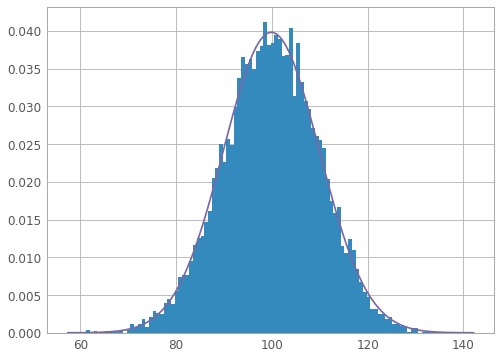

In [121]:
# scipy norm fit is going fucking wild... let's experiment with it
data = np.random.normal(loc=100, scale=10, size=10000)
plt.hist(data, bins=100, density=True)
fit_mean, fit_std = stats.norm.fit(data)
print(fit_mean, fit_std)
mean = np.mean(data)
std = np.std(data)
print(mean, std)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, stats.norm.pdf(x, mean, std))

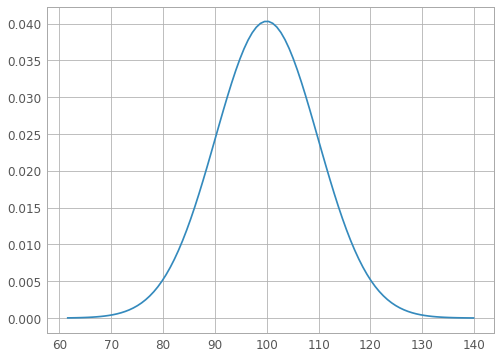

In [120]:
plt.plot(x, stats.norm.pdf(x, mean, std))

In [177]:
# let's try to assume a value of 100 eps for the background noise
# what is that in counts?
gain = 31335183770000.0
exp_time = 1200
100*10*exp_time

1200000

# -7.512851e-12*gain

In [207]:
40*10*1200

480000